# **Loan approval**

# Introduction

Our goal is to train a model that will predict whether bank should allow the loan based on applicants status.

We put the csv files into sample_data folder.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [ ]:
train = pd.read_csv("/content/sample_data/loan_approval_train.csv")
test = pd.read_csv("/content/sample_data/loan_approval_test.csv")

FileNotFoundError: ignored

# Exploration Analysis

First, we explore the data - How does it look like? What attributes can be seen? What types of attributes are present? What attributes are useless and can be dropped?
Just by looking at head of the dataset we can see Loan_ID will be redundant.

In [ ]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


By using describe we can notice that if we compare median and the maximum value of ApplicantIncome and CoapplicantIncome we can see that there might be an outlier in the data.
We can also notice that the count of LoanAmount, Loan_Amount_Term and Credit_History is lower than the other two attributes suggesting there will be some missing values.
By looking at the mean arge portion of the data includes applicants with Credit_History (since it's a binary attribute).

In [ ]:
train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


Looking at dataset info we can see that there are a lot of object type attributes which we'll have to deal with later.

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


Now we'll look at the distribution of the data.
This representation shows the information we've seen in written form before and confirms our presumptions, for example that ApplicantIncome and CoapplicantIncome data features some outliers or that the majority of applicants have Credit_History.

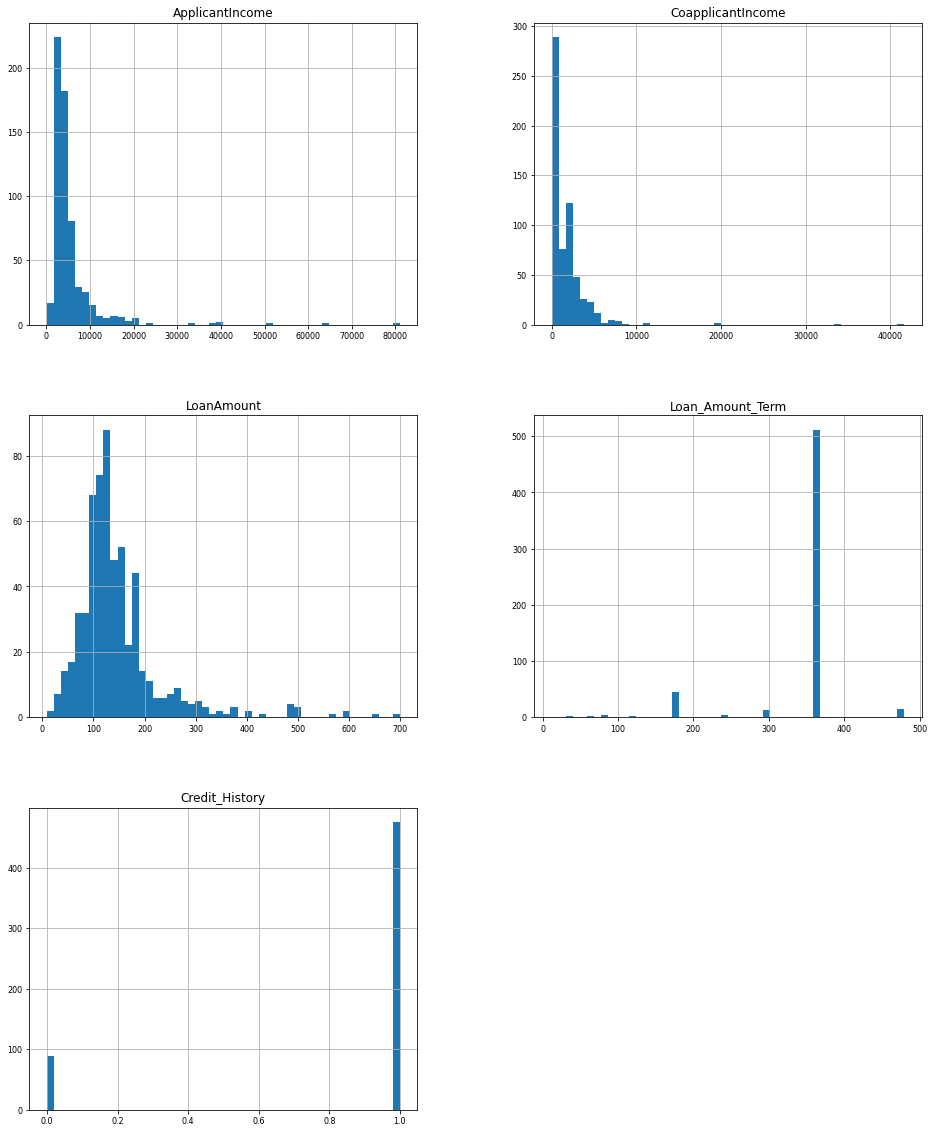

In [ ]:
list(set(train.dtypes.tolist()))
num_features = train.select_dtypes(include = ['float64', 'int64'])
num_features.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

Now we plot pairwise relationships in a dataset using pairplot.

We can clearly identify some relationships with LoanAmount in the first set of diagrams. A lot of datapoints are located on x = 0, which may indicate the absence of such feature.

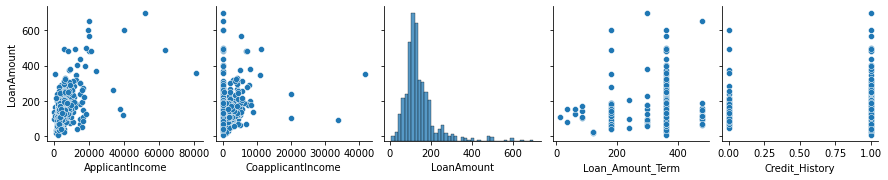

In [ ]:
for i in range(0, len(num_features.columns), 5):
    sns.pairplot(data=num_features,
                x_vars=num_features.columns[i:i+5],
                y_vars=['LoanAmount'])

Now we want to look at numerical attributes relationships with Loan_Status, since that's our target value. We use it as a hue in this case.

We can for example see that high ApplicantIncome in relationship with lower CoapplicantIncome are rewarded more often with allowance of loan and that high CoapplicantIncome data doesn't neccessarily mean that they will be allowed to get a loan, which can be a surprising discovery.

We can also notice that almost all applicants and coapplicants have less than average income yet the loan allowance distribution is quite even.

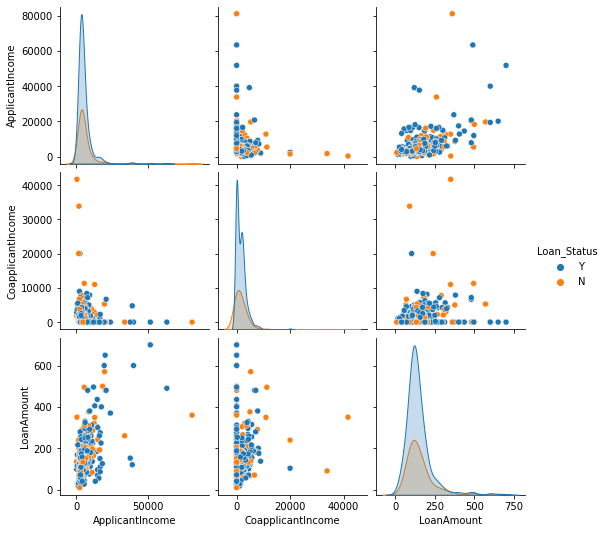

In [ ]:
sns.pairplot(train, vars=["ApplicantIncome", "CoapplicantIncome", "LoanAmount"], hue="Loan_Status")

We turn all object types to category types so it's easier and more efficient to work with them.

In [ ]:
for col in train.select_dtypes(include="object"):
  train[col] = train[col].astype("category")

We want to look at distribution of categorical data now. We can see that majority of applicants are males, married, educated, employees and have 0 dependents. Distribution of Property_Area seems pretty even.

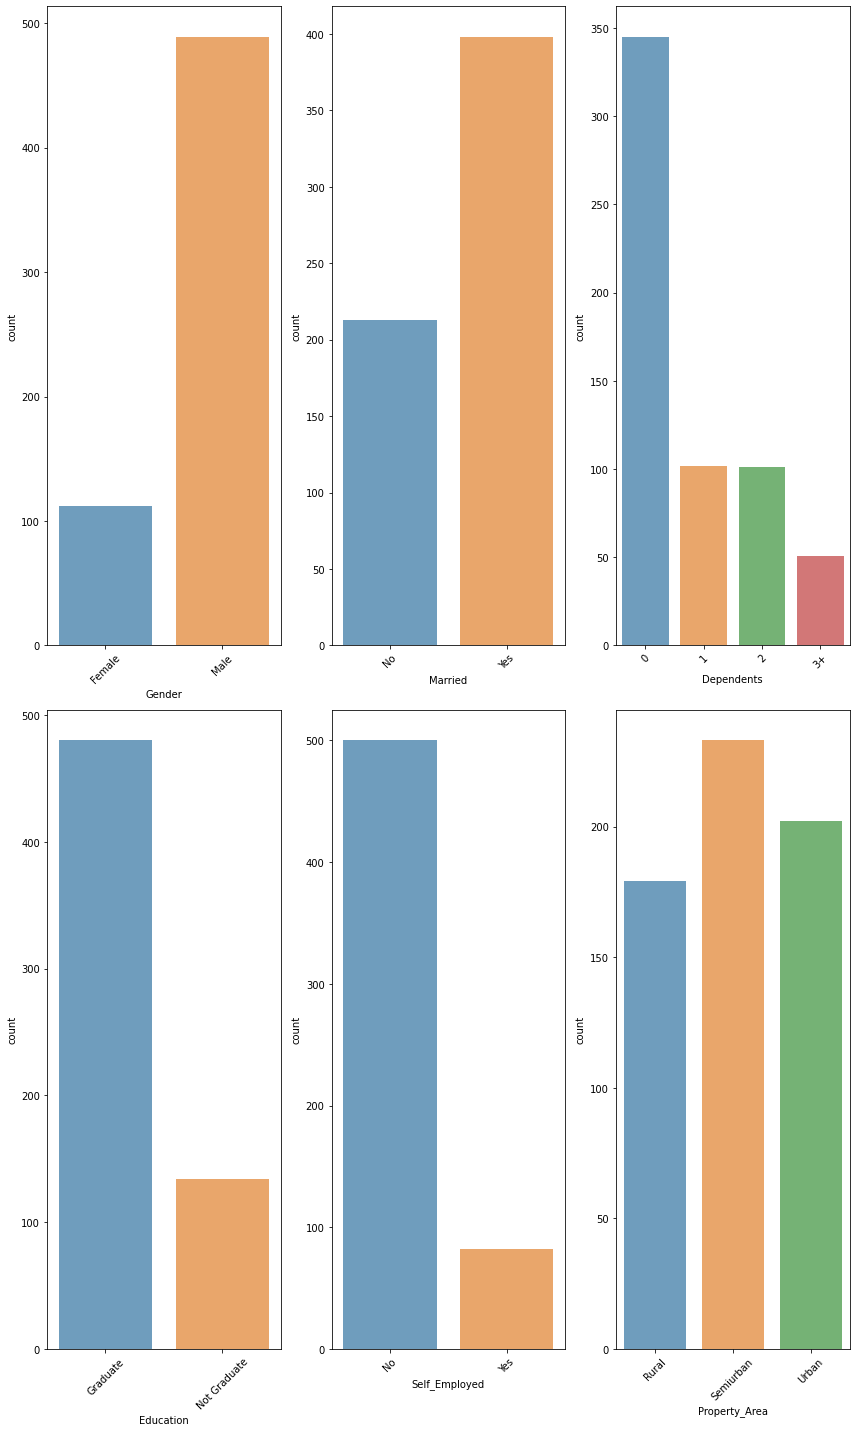

In [ ]:
cat_features = train.select_dtypes(include = ['category']).drop(columns=["Loan_ID"])

fig, axes = plt.subplots(round(len(cat_features.columns) / 3), 3, figsize=(12, 20))

for i, ax in enumerate(fig.axes):
    if i < len(cat_features.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=cat_features.columns[i], alpha=0.7, data=cat_features, ax=ax)

fig.tight_layout()

Let's look at relationships of categorical attributes with Loan_Status. Not surprising discovery is that educated  people have higher chance of getting a loan. It can be surprising that applicants with semiurban Property_Area have more luck getting a loan. We can also see that there's a slight disproportion between married and unmarried applicants.

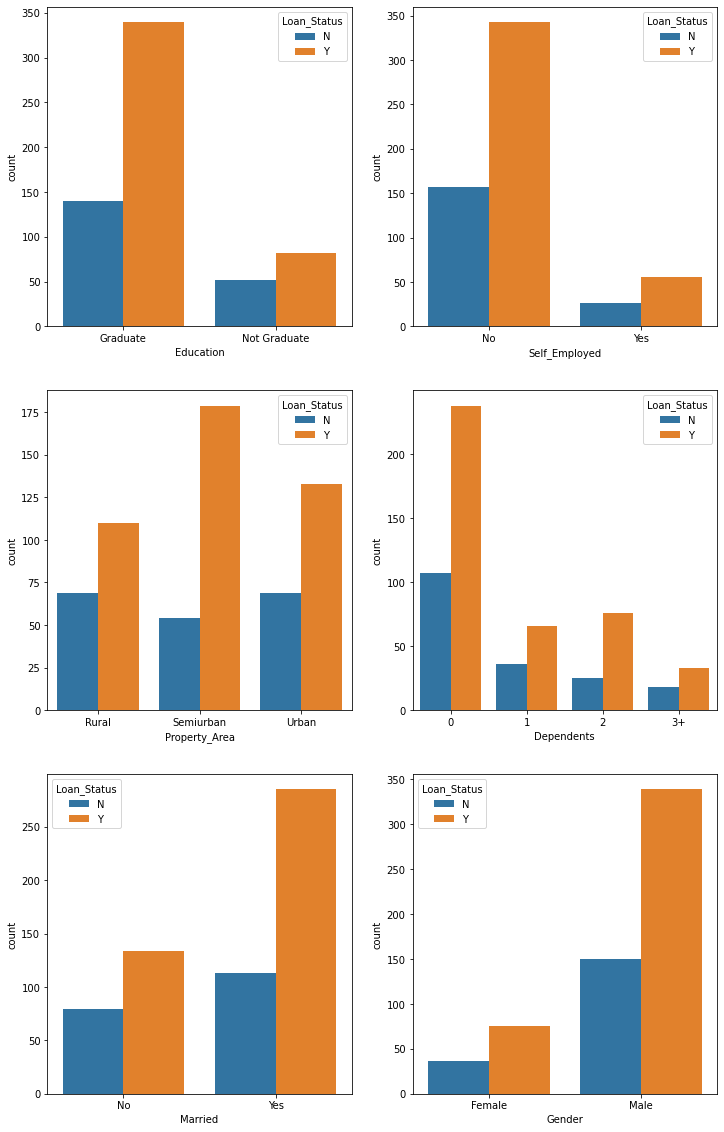

In [ ]:
cat_feat_list = ["Education", "Self_Employed", "Property_Area", "Dependents", "Married", "Gender"]

fig, ax = plt.subplots(3, 2, figsize=(12, 20))

for i, ax in enumerate(fig.axes):
  sns.countplot(x=cat_feat_list[i], hue="Loan_Status", data=train, ax=ax)

fig.show()

# Preprocessing

In preprocessing part we will drop redundant attributes, take care of missing values and divide the train dataset to X and y data (our target y value will be Loan_Status).

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

We drop Loan_ID, since it has no informational value in this case.

In [ ]:
train = train.drop(columns=["Loan_ID"])
test = test.drop(columns=["Loan_ID"])

By looking at number of missing values we can see there's not a lot to take care of, maybe around 12% of the training data.

In [ ]:
print(train.isna().sum())

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


We replace binary values of Loan_Status "Y" and "N" by numbers so it's easier to work with.

In [ ]:
cleanup_nums = {"Loan_Status": {"Y": 1, "N": 0}}
train = train.replace(cleanup_nums)

Main division into X and y data.

In [ ]:
X = train.drop(columns=["Loan_Status"])
y = train["Loan_Status"]

Here we impute the missing values with SimpleImputer using the most_frequent strategy on categorical data and mean strategy on numerical data. Afterwards we encode the categorical data using OneHotEncoder and scale the numerical values with StandardScaler. We use ColumnTransformer to transform the whole portion of X data.

In [ ]:
num_features = X.select_dtypes("number").columns
cat_features = X.select_dtypes(include = ['category']).columns

cat_pipeline = Pipeline(
    [("imputer", SimpleImputer(strategy="most_frequent")), ("onehot", OneHotEncoder())]
)

num_pipeline = Pipeline(
    [("imputer", SimpleImputer(strategy="mean")), ("std_scaler", StandardScaler())]
)


col_transformer = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ]
)

X_edited = col_transformer.fit_transform(X)
test = col_transformer.fit_transform(test)

This part of the code is just to see that there are no missing values left. The dummies are implemented with names of columns so we can notice how data was decomposed (mainly the categorical values) after transforming it.

In [ ]:
cat_feat_list = ["Education", "Self_Employed", "Property_Area", "Dependents", "Married", "Gender"]

X_cat_edited = X
for cat_feature in cat_feat_list:
    dataset_edit = pd.get_dummies(X[cat_feature], prefix=cat_feature, prefix_sep="_")
    X_cat_edited = pd.concat([X_cat_edited, dataset_edit], axis=1)
    X_cat_edited = X_cat_edited.drop(columns=[cat_feature], axis=1)

X_as_dataset = pd.DataFrame(data=X_edited, columns=X_cat_edited.columns)
print(X_as_dataset.isna().sum())

ApplicantIncome            0
CoapplicantIncome          0
LoanAmount                 0
Loan_Amount_Term           0
Credit_History             0
Education_Graduate         0
Education_Not Graduate     0
Self_Employed_No           0
Self_Employed_Yes          0
Property_Area_Rural        0
Property_Area_Semiurban    0
Property_Area_Urban        0
Dependents_0               0
Dependents_1               0
Dependents_2               0
Dependents_3+              0
Married_No                 0
Married_Yes                0
Gender_Female              0
Gender_Male                0
dtype: int64


In [ ]:
X_as_dataset

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Married_No,Married_Yes,Gender_Female,Gender_Male
0,0.072991,-0.554487,0.000000,0.279851,0.451640,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-0.134412,-0.038732,-0.219273,0.279851,0.451640,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,-0.393747,-0.554487,-0.957641,0.279851,0.451640,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,-0.462062,0.251980,-0.314547,0.279851,0.451640,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,0.097728,-0.554487,-0.064454,0.279851,0.451640,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,-0.410130,-0.554487,-0.898095,0.279851,0.451640,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
610,-0.212557,-0.554487,-1.267279,-2.518655,0.451640,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
611,0.437174,-0.472404,1.269371,0.279851,0.451640,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
612,0.357064,-0.554487,0.483367,0.279851,0.451640,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


# Models

5 different models were chosen:
*   Logistic Regression (as baseline model)
*   Decision Tree Classification
*   K-Nearest Neighbours Classification
*   Random Forest Classification
*   C-Support Vector Classification


We will fit and predict the models on our data and then evaluate it using following metrics:
*   Classification accuracy (percentage of correct predictions, higher value = better classifier)
*   Weighted average F1-score (harmonic mean of precision and recall which gives a better measure of the incorrectly classified cases than the accuracy metric, higher value = better classifier)
*   Precision recall curve (shows the tradeoff between precision and recall for different threshold)
*   Confusion matrix (describes the performance of a classification model)
    *   True Positives (11): we correctly predicted that they will be allowed to get loan
    *   True Negatives (00): we correctly predicted that they won't be allowed to get loan
    *   False Positives (01): we incorrectly predicted that they will be allowed to get loan
    *   False Negatives (10): we incorrectly predicted that they won't be allowed to get loan
*   Receiver operating characteristic curve (graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied)
*   ROC AUC (percentage of the ROC plot that is underneath the curve, higher value = better classifier)


We'll also try to find the best hyper parameters for selected models by using GridSearchCV and evaluate the best classifier F1-score.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [ ]:
def evaluate_model(model, X, y, grid_params, grid_search = True):
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
  model_pipe = make_pipeline(StandardScaler(), model)
  pred_y = model_pipe.fit(x_train, y_train).predict(x_test)
  pred_train = model_pipe.fit(x_train, y_train).predict(x_train)

  acc = accuracy_score(y_test, pred_y)
  print("Classification accuracy:", acc, "(" + str(round(acc*100, 2)) + "%)")
  acc_train = accuracy_score(y_train, pred_train)
  print("Train classification accuracy:", acc_train, "(" + str(round(acc_train*100, 2)) + "%)")

  f1sc = f1_score(pred_y, y_test, average="weighted");
  print("\nWeighted average F1-score:", f1sc, "(" + str(round(f1sc*100, 2)) + "%)")
  f1sc_train = f1_score(pred_train, y_train, average="weighted");
  print("Train weighted average F1-score:", f1sc_train, "(" + str(round(f1sc_train*100, 2)) + "%)")

  print("\nPrecision Recall Curve")
  plot_precision_recall_curve(model, x_test, y_test)
  plt.show()

  print("\nConfusion Matrix")
  plot_confusion_matrix(model, x_test, y_test)
  plt.show()

  print("\nReceiver Operating Characteristic (ROC) Curve")
  plot_roc_curve(model, x_test, y_test)
  plt.show()

  # auc = roc_auc_score(y_test, pred_y)
  # print("\nROC AUC score:", auc, "(" + str(round(auc*100, 2)) + "%)")

  # print("\nClassification Report")
  # target_names = [str(i) for i in range(10)]
  # print(classification_report(y_test, pred_y))

  if not grid_search:
    return

  gscv = GridSearchCV(model, grid_params, cv=10, scoring="f1", n_jobs=-1)
  gscv.fit(x_train, y_train)

  print("\nBest hyper parameters:", gscv.best_params_)

  best_dtc = gscv.best_estimator_
  print("\nBest classifier evaluation:")
  print(best_dtc)

  gscv_pred = gscv.predict(x_test)

  acc = accuracy_score(y_test, gscv_pred)
  print("\nGSCV classification accuracy:", acc, "(" + str(round(acc*100, 2)) + "%)")
  acc_train = accuracy_score(y_train, gscv.predict(x_train))
  print("GSCV train classification accuracy:", acc_train, "(" + str(round(acc_train*100, 2)) + "%)")

  gscvf1 = f1_score(gscv_pred, y_test, average="weighted")
  print("\nWeighted average grid search F1-score:",  gscvf1, "(" + str(round(gscvf1*100, 2)) + "%)")

  print('\nGrid Search fitted confusion matrix')
  plot_confusion_matrix(best_dtc, x_test, y_test)
  plt.show()

  print("\nGrid Search fitted ROC Curve")
  plot_roc_curve(best_dtc, x_test, y_test)
  plt.show()

  # test_pred = model.predict(test)
  # for i in range(len(test_pred)):
	#   print("X=%s, Predicted=%s" % (test[i], test_pred[i]))

**Logistic Regression**

We chose Logistic Regression as our baseline model, because it is one of the simplest machine learning algorithms and often used for binary classification problems, it's efficient and has a good accuracy for more simple datasets.

Logistic regression is an extension to the linear regression algorithm, it also uses an equation as the representation, though, instead of predicting the actual continuous value, we predict the probability of an outcome. It works better when there is not a lot of categorical data.
Input values (x) are combined linearly using weights or coefficient values to predict an output value (y). A key difference from linear regression is that the output value being modeled is a binary values (0 or 1) rather than a numeric value (that's why logistic regression is so often used for solving binary classification problems). The coefficient values are estimated from the training data using maximum-likelihood estimation (learning algorithm used by a variety of machine learning algorithms).

In [ ]:
grid_params = {
    "penalty": ['l1', 'l2', 'elasticnet', 'none'],
    "C": [0.0, 0.001, 0.01, 0.1, 1.0],
    "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    "max_iter": [10, 50, 100, 150, 200],
}
evaluate_model(LogisticRegression(), X_edited, y, grid_params)

**Decision Tree Classification**

Decision trees are used for classification as well as regression. They split data into smaller and smaller subsets using entropy and divide the tree into decision nodes and leaf nodes. Basically they create a flowchart where the leaf nodes represent classification outputs/decisions. It's computationally very cheap, but prune to overfitting. We opted for this model mainly because it's one of the most commonly used models for classification problems.

In [ ]:
grid_params = {
    "max_depth": [3, 5, 10, 20, 50],
    "min_samples_leaf": [1, 3, 5, 7, 10],
    "criterion": ['gini"', 'entropy'],
    "ccp_alpha": [0.0, 0.001, 0.01, 0.1, 0.3],
}
evaluate_model(DecisionTreeClassifier(), X_edited, y, grid_params)

**K-Nearest Neighbours Classification**

We chose K-Nearest Neighbours because it is often used for classification problems, though, it's mainly good for multiclass classification. In our case we work with binary classification problem but we wanted to see how it does in comparison to other models.

The K-nearest neighbors (KNN) algorithm is a type of supervised machine learning algorithms. It is simple and yet performs quite complex classification tasks, though it has harder time dealing with categorical values.
It works by calculating the distance of a new data point to all other training data points. The distance can be of any type for example Euclidean or Manhattan. It then selects the K-nearest data points, where K can be any integer. Finally it assigns the data point to the class to which the majority of the K data points belong. It basically keeps a collection of all distances which is then sorted, first K entries are picked and since this is a classification problem, the mode of K labels is returned (if it was a regression problem, the mean of K labels would be the outcome).

In [ ]:
grid_params = {
    "n_neighbors": [1, 5, 10, 15, 20],
    "weights": ['uniform', 'distance'],
    "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
    "metric": ['euclidean', 'manhattan', 'minkowski'],
}
evaluate_model(KNeighborsClassifier(), X_edited, y, grid_params)

**Random Forest Classification**

Random forest takes a number of decision tree classifiers and fits them on various sub-samples of the dataset. It uses averaging to improve the predictive accuracy and control over-fitting. It works well even without hyperparameters. We chose this classifier because we thought it might be interesting to see how it works compared to a  Decision Tree especially without fitting it's hyperparameters since that often results in errors.

In [ ]:
evaluate_model(RandomForestClassifier(), X_edited, y, grid_params, False)

**C-Support Vector Classification (SVC)**

C-Support Vector (SVC) is one of Support Vector Machines (SVM). We chose SVM because it's used to solve variety of problems, not only classification and it's very versatile. We wanted to see how it performs compared to other modules.

SVM can be used for classification (either binary or multiclass), regression and outliers detection. It can easily handle multiple continuous and categorical variables.
It works by constructing a hyperplane (decision plane which separates between a set of objects having different class memberships) in multidimensional space to separate different classes. SVM generates optimal hyperplane in an iterative manner, which is used to minimize an error. The core idea of SVM is to find a maximum marginal hyperplane (MMH) that best divides the dataset into classes. Support vectors are the data points, which are closest to the hyperplane. The objective is to select a hyperplane with the maximum possible margin (distance between the either nearest points) between support vectors in the given dataset.

In [ ]:
print("C-Support Vector (SVC)")
grid_params = {
    "C": [0.0001, 0.001, 0.1, 0.3, 1.0],
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "gamma": ['scale', 'auto'],
    "max_iter": [-1, 0, 1, 10, 50],
}
evaluate_model(SVC(), X_edited, y, grid_params)

# Conclusion

We noticed that SVC and Logistic Regression models are slightly more effective in this case and that Decision Tree's results seems to be less accurate. The rest of the models are more-less the same.

Default testing data sample is 0.25, though when trying out smaller portion of data we noticed few models having a tad better accuracy, mainly Decision Tree, which went from 62% to 72% (the rest only increased by few percent), on the other hand Logistic Regression showed worse results.
When trying higher amount of training all of the models had a bit better accuracy.

We noticed that GridSearchCV takes longest for Logistic Regression and shortest for K-Nearest Neighbours. By fitting hyperparameter with GridSearchCV majority od models showed a slightly better results.

To compare our baseline Logistic Regression model with the others, it's a bit surprising it's doing better, with higher accuracy although it's search for the right hyper parameters is quite long. It might be because the dataset is more simple and this problem is binary classification for which Logistic Regression works the best.

Best accuracy: *Logistic Regression/SVC*

Worst accuracy: *Decision Tree*


Best weighted average F1-score: *SVC*

Worst weighted average F1-score: *Decision Tree*


Best ROC AUC score: *Logistic Regression*

Worst ROC AUC score: *Decision Tree*


Best weighted average grid search F1-score: *K-Nearest Neighbours*

Worst weighted average grid search F1-score: *Decision Tree*

